In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [2]:
tau = 3.052*60

def p_pdf(t, tau=tau):
    return (np.log(2)/tau)*2**(-t/tau)

def p_cdf(t, tau=tau):
    return 1 - 2**(-t/tau)

def p_icdf(t, tau=tau):
    return -tau*np.log2(1 - t)

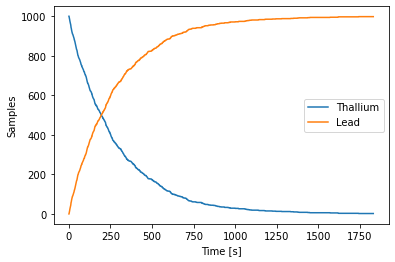

In [3]:
np.random.seed(1234)
z = np.random.random(1000)

time = np.arange(0, int(10*tau), 1)

Tl = np.zeros(len(time))+1000
Pb = np.zeros(len(time))

for t in time:
    count = 0
    p = p_cdf(t)
    for i in range(1000):
        if z[i] < p:
            count += 1
    Tl[t] -= count
    Pb[t] += count

plt.plot(time, Tl, label='Thallium')
plt.plot(time, Pb, label='Lead')
plt.xlabel('Time [s]')
plt.ylabel('Samples')
plt.legend()
plt.show()

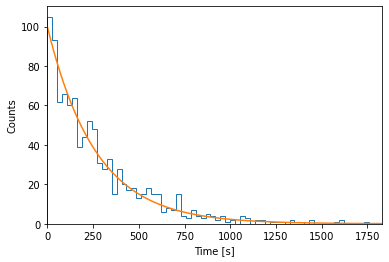

In [4]:
np.random.seed(1234)
z = np.random.random(1000)
d = p_icdf(z)
n, edges, patches = plt.hist(d, histtype='step', bins=100)
plt.plot(time, (tau/np.log(2))*100*p_pdf(time))
plt.xlim(0,time[-1])
plt.xlabel('Time [s]')
plt.ylabel('Counts')
plt.show()

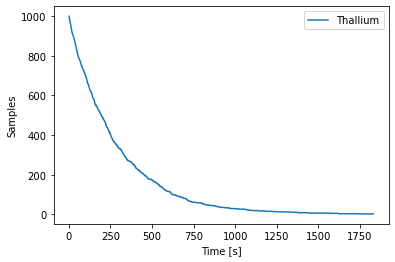

In [5]:
Tl = np.zeros(len(time))+1000

for t in time:
    count = 0
    for i in range(1000):
        if d[i] < t:
            count += 1
    Tl[t] -= count
    
plt.plot(time, Tl, label='Thallium')
plt.xlabel('Time [s]')
plt.ylabel('Samples')
plt.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [6]:
#physical dimensions analysis

# num
Z = 79
e = 1.602176634      #*10**(-19) #C
# den
eps_0 = 8.8541878128 #*10**(-12) #C^(2)*N^(-1)*m^(-2)
E = 7.7*e            #*10**6     #N*m
a_0 = 5.29177210903  #*10**(-11) #m
sigma = a_0          #*10**(-2)  #m

b_max_th = (Z*e**2)/(2*np.pi*eps_0*E*sigma) 

In [7]:
np.random.seed(1234)
n_particles = 10**5

# adimensional beam distribution
mean = [0, 0]
cov = [[1, 0], [0, 1]]
x, y = np.random.multivariate_normal(mean, cov, n_particles).T

count = 0
b_max = 0
for i in range(n_particles):
    # impact parameter
    b = np.sqrt(x[i]**2 + y[i]**2)
    # scattering angle
    theta = 2*np.arctan(b_max_th/b)
    if theta > 0.5*np.pi:
        count += 1
        if b > b_max:
            # update max impact parameter
            b_max = b

print('fraction of bouncing particles:', '{:.2f}'.format(100*count/n_particles), '%')
print('experimental max impact parameter:', '{:.2e}'.format(b_max*sigma*10**(-13)), 'm')
print('theoretical max impact parameter:', '{:.2e}'.format(b_max_th*sigma*10**(-13)), 'm')

fraction of bouncing particles: 0.13 %
experimental max impact parameter: 2.95e-14 m
theoretical max impact parameter: 2.95e-14 m


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function

$$
f(x) =\sin^2{\frac{1}{x(2-x)}}
$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

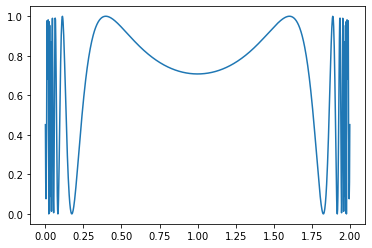

In [8]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x = np.linspace(0.001, 1.999, 1000)
plt.plot(x, f(x))

The integral obtained with 1000000 samples is: 1.450564


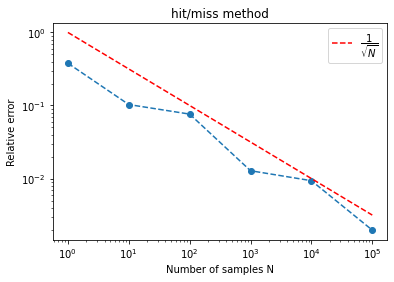

In [9]:
np.random.seed(1234)

# Monte Carlo integration
def Monte_Carlo(N):
    count = 0
    for i in range(N):
        x = 2*np.random.random()
        y = 1*np.random.random()
        if y < f(x):
            count += 1
    return 2*1*count/N

N = 10**6
best = Monte_Carlo(N)
print('The integral obtained with', N, 'samples is:', best)

samples = [10**i for i in range(6)]
err = np.zeros(6)

for i in range(0, 6):
    err[i] = np.abs(Monte_Carlo(samples[i]) - best)/best
    
plt.plot(samples, err, 'o--')
plt.plot(samples, 1/np.sqrt(samples), 'r--', label=r'$\dfrac{1}{\sqrt{N}}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples N')
plt.ylabel('Relative error') # w.r.t best 
plt.title('hit/miss method')
plt.legend()
plt.show()

The integral obtained with 1000000 samples is: 1.4512644165778905


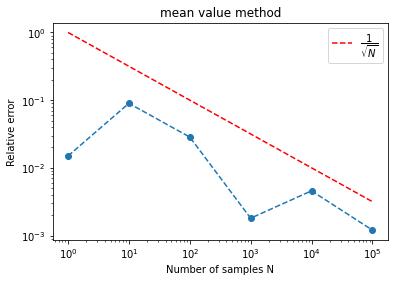

In [10]:
np.random.seed(1234)

# Monte Carlo integration: mean value method
def Monte_Carlo_mv(N):
    add = 0
    for i in range(N):
        x = 2*np.random.random()
        add += f(x) 
    return 2*add/N

N = 10**6
best_mv = Monte_Carlo_mv(N)
print('The integral obtained with', N, 'samples is:', best_mv)

samples = [10**i for i in range(6)]
err_mv = np.zeros(6)

for i in range(0, 6):
    err_mv[i] = np.abs(Monte_Carlo_mv(samples[i]) - best_mv)/best_mv
    
plt.plot(samples, err_mv, 'o--')
plt.plot(samples, 1/np.sqrt(samples), 'r--', label=r'$\dfrac{1}{\sqrt{N}}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples N')
plt.ylabel('Relative error') # w.r.t best_mv
plt.title('mean value method')
plt.legend()
plt.show()

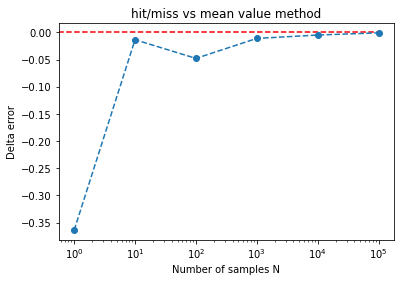

In [11]:
delta_err = (err_mv - err)

plt.plot(samples, delta_err, 'o--')
plt.hlines(0, 0, 10**5, 'r', '--')
plt.xscale('log')
plt.xlabel('Number of samples N')
plt.ylabel('Delta error')
plt.title('hit/miss vs mean value method')
plt.show()

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [12]:
# 2-D case with hit/miss method
np.random.seed(1234)

# Monte Carlo integration
def Monte_Carlo(N):
    count = 0
    for i in range(N):
        x = 2*np.random.random() - 1
        y = 2*np.random.random() - 1
        if (x**2 + y**2) <= 1:
            count += 1
    return 2*2*count/N

N = 10**5
V1 = Monte_Carlo(N)
print('The volume of a 2 dimensional unit sphere obtained with', N, 'samples is:', V1)

The volume of a 2 dimensional unit sphere obtained with 100000 samples is: 3.13892


In [13]:
# n-D case with hit/miss method
np.random.seed(1234)

# Monte Carlo integration
def Monte_Carlo_D(N, D):
    count = 0
    for i in range(N):
        x = np.array([2*np.random.random()-1 for i in range(D)])
        if np.sum(x**2) <= 1:
            count += 1
    return (2**D)*count/N

N = 10**5
D = 10
V2 = Monte_Carlo_D(N, D)
print('The volume of a', D, 'dimensional unit sphere obtained with', N, 'samples is:', V2)

The volume of a 10 dimensional unit sphere obtained with 100000 samples is: 2.5088


In [14]:
# n-D case with mean value method
np.random.seed(1234)

# Monte Carlo integration: mean value method
def Monte_Carlo_D_mv(N, D):
    add = 0
    for i in range(N):
        x = np.array([2*np.random.random()-1 for i in range(D-1)])
        if np.sum(x**2) <= 1:
            # the 2 factor is needed since I take only the upper half function for a (D-1) unit sphere
            add += 2*np.sqrt(1 - np.sum(x**2))
    return (2**(D-1))*add/N

N = 10**5
D = 10
V2 = Monte_Carlo_D_mv(N, D)
print('The volume of a', D, 'dimensional unit sphere obtained with', N, 'samples is:', V2)

The volume of a 10 dimensional unit sphere obtained with 100000 samples is: 2.69535468594818


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

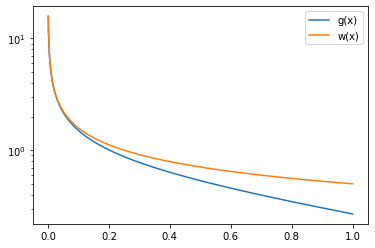

In [15]:
def g(x):
    return 1/(np.sqrt(x)*(np.exp(x) + 1))

def w(x):
    # normalized between 0 and 1
    return 0.5/np.sqrt(x)

x = np.linspace(0.001, 1, 1000)
plt.plot(x, g(x), label='g(x)')
plt.plot(x, w(x), label='w(x)')
plt.yscale('log')
plt.legend()
plt.show()

In [16]:
# Monte Carlo integration: importance sampling
def Monte_Carlo_is(N):
    add = 0
    for i in range(N):
        # x = z**2 where z is sampled from a uniform distribution
        x = np.random.random()**2
        add += g(x)/w(x)
    # w is normalized
    return (1/N)*add*1

N = 10**5
I = Monte_Carlo_is(N)
print('The integral obtained with', N, 'samples is:', I)

The integral obtained with 100000 samples is: 0.8387526653632336
